# Tutorial 1. The Measurement Control 

This tutorial covers basic usage of quantify focusing on running basic experiments using `MeasurementControl`. 
The `MeasurementControl` is the main `Instrument` in charge of running any experiment. It takes care of saving the data in a standardized format as well as live plotting of the data during the experiment. 
`quantify` makes a distinction between `soft`(ware) controlled measurements and `hard`(ware) controlled measurements. 

In a `soft` measurement `MeasurementControl` is in charge of the measurement loop and consecutively sets and gets datapoints. A `soft` measurement can be 1D, 2D or higher dimensional and also supports adaptive measurements in which the datapoints are determined during the measurement loop. 

In a `hard` measurement the hardware (such as an AWG or a central controller) is in charge of the measurement loop. In this case, the datapoints to be acquired are determined before the experiment starts and are precompiled into the hardware which is then armed and starts acquisition. In a `hard` measurement `MeasurementControl` does not take care of the measurement loop but still takes care of the data storage and live plotting of the experiment. 

In [1]:
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt 
from qcodes import ManualParameter, Parameter
%matplotlib inline

In [2]:
from quantify.measurement import MeasurementControl


In [3]:
MC = MeasurementControl('MC')

## Define a simple model 

In [4]:
from time import sleep

In [5]:
sleep(.1)

In [6]:

def CosFunc(t, amplitude, frequency, phase, offset):
    """A simple cosine function"""
    return amplitude * np.cos(2 * np.pi * frequency * t + phase) + offset

# Parameters are created to emulate a system being measured 
amp = ManualParameter('amp', initial_value=1, unit='V', label='Amplitude')
freq = ManualParameter('freq', initial_value=.5, unit='Hz', label='Frequency')
t = ManualParameter('t', initial_value=1, unit='s', label='Time')
phi = ManualParameter('phi', initial_value=0, unit='Rad', label='Phase')

acq_delay = ManualParameter('acq_delay', initial_value=.1, unit='s')

def cosine_model():
    sleep(acq_delay())
    return CosFunc(t(), amp(), freq(), phase=phi(), offset=0)

# We wrap our function in a Parameter to be able to give 
sig = Parameter(name='sig', label='Signal level', unit='V', get_cmd=cosine_model)

In [7]:
oneD=np.linspace(0, 10, 100)
MD = (np.zeros((100, 2)))

In [8]:
from importlib import reload


In [9]:
freq(.9)

In [10]:
MC.set_setpars(t)
MC.set_setpoints(np.linspace(0, 5, 50))
MC.set_getpars(sig)
dset = MC.run('Cosine test')


 100% completed 	elapsed time: 5.2s 	time left: 0.0s


In [11]:
dset

<xarray.Dataset>
Dimensions:  (dim_0: 50)
Dimensions without coordinates: dim_0
Data variables:
    x0       (dim_0) float64 0.0 0.102 0.2041 0.3061 ... 4.694 4.796 4.898 5.0
    y0       (dim_0) float64 1.0 0.8381 0.4048 -0.1596 ... -0.4048 -0.8381 -1.0
Attributes:
    tuid:     20200430-185023-32e071

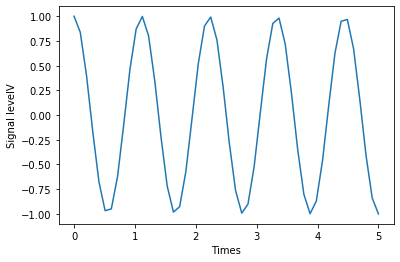

In [12]:
f,ax = plt.subplots()

ax.set_xlabel(dset['x0'].attrs['long_name']+ dset['x0'].attrs['unit'])
ax.set_ylabel(dset['y0'].attrs['long_name']+ dset['y0'].attrs['unit'])

ax.plot(dset['x0'], dset['y0'])

In [13]:
dset.attrs['tuid']

'20200430-185023-32e071'

## Below is for testing

In [14]:
import quantify.visualization.pyqt_plotmon as pqm
reload(pqm)

plotmon = pqm.PlotMonitor_pyqt('plotmon1')


In [15]:
tuid =dset.attrs['tuid']
plotmon.tuid(tuid)
plotmon.tuid(tuid)

In [ ]:
e

In [17]:
plotmon.update_plotmon()

In [32]:
from qcodes.plots.pyqtgraph import QtPlot, TransformState
from qcodes.plots.colors import color_cycle

In [34]:
plot_mon = QtPlot(window_title='Test 
                  ', figsize=(600,400))

In [35]:
plot_mon.clear()

In [36]:
dset

<xarray.Dataset>
Dimensions:  (dim_0: 50)
Dimensions without coordinates: dim_0
Data variables:
    x0       (dim_0) float64 0.0 0.102 0.2041 0.3061 ... 4.694 4.796 4.898 5.0
    y0       (dim_0) float64 1.0 0.9491 0.8014 0.5721 ... -0.8014 -0.9491 -1.0
Attributes:
    tuid:     20200430-173337-2141d4

In [80]:
p = plot_mon.add(x=dset['x0'].values, y=dset['y0'].values, subplot=1, 
            xlabel=dset['x0'].attrs['long_name'], xunit=dset['x0'].attrs['unit'], 
            ylabel=dset['y0'].attrs['long_name'], yunit=dset['y0'].attrs['unit'], 
            symbol='o', symbolSize=5,
            )

In [88]:
plot_mon.traces[0]['config']['y']=y

In [89]:
plot_mon.update_plot()

In [97]:
list(filter(lambda k: 'x' in k, dset.keys()))

['x0']

In [94]:
if 'x0' in dset.keys()

SyntaxError: invalid syntax (<ipython-input-94-fa82cfee2bc8>, line 1)

In [92]:
len(dset.keys())

2

In [ ]:
plot_mon.add()

In [23]:
from quantify.measurement.measurement_control import gen_tuid

In [24]:
def _initialize_dataset(self):
    """
    Initialize an empty dataset based on
        mode, setables, getable_pars and _setable_pars

    """
    darrs = []
    for i, setpar in enumerate(self._setable_pars):
        darrs.append(xr.DataArray(
            data=self._setpoints[:, i],
            name='x{}'.format(i),
            attrs={'name': setpar.name, 'long_name': setpar.label,
                   'unit': setpar.unit}))

    numpoints = len(self._setpoints[:, 0])
    for j, getpar in enumerate(self._getable_pars):
        empty_arr = np.empty(numpoints)
        empty_arr[:] = np.nan
        darrs.append(xr.DataArray(
            data=empty_arr,
            name='y{}'.format(i),
            attrs={'name': getpar.name, 'long_name': getpar.label,
                   'unit': getpar.unit}))

    self._dataset = xr.merge(darrs)
    self._dataset.attrs['tuid'] = gen_tuid()

In [26]:
_initialize_dataset(MC)

MC._dataset

<xarray.Dataset>
Dimensions:  (dim_0: 20)
Dimensions without coordinates: dim_0
Data variables:
    x0       (dim_0) float64 5e+09 5.01e+09 5.02e+09 ... 5.18e+09 5.19e+09
    y0       (dim_0) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    tuid:     20200429-165120-d80501

In [15]:
MC._setable_pars

[<qcodes.instrument.parameter.ManualParameter: freq at 4691160784>]

In [17]:
np.shape(MC._setpoints)

(20, 1)

In [20]:
MC._getable_pars[0].name

'sig'

In [12]:
MC.__str__??

Signature:      MC.__str__()
Call signature: MC.__str__(*args, **kwargs)
Type:           method-wrapper
String form:    <method-wrapper '__str__' of MeasurementControl object at 0x1179bb850>
Docstring:      Return str(self).


In [14]:
MC.__repr__??

Signature: MC.__repr__() -> str
Source:   
    def __repr__(self) -> str:
        """Simplified repr giving just the class and name."""
        return '<{}: {}>'.format(type(self).__name__, self.name)
File:      /usr/local/lib/python3.7/site-packages/qcodes/instrument/base.py
Type:      method


In [19]:
isinstance([freq,], (list, tuple))

True

In [22]:
del freq.unit


In [23]:
freq

<qcodes.instrument.parameter.ManualParameter: freq at 4715851664>

In [24]:
freq.unit

AttributeError: 'ManualParameter' object has no attribute 'unit'

In [7]:
from qcodes.instrument.parameter import MultiParameter
MultiParameter

qcodes.instrument.parameter.MultiParameter

In [13]:
dset = MC._dataset
dset 

<xarray.Dataset>
Dimensions:  (dim_0: 101)
Dimensions without coordinates: dim_0
Data variables:
    x0       (dim_0) float64 0.0 0.1 0.2 0.3 0.4 0.5 ... 9.6 9.7 9.8 9.9 10.0
    y0       (dim_0) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    tuid:     20200425-120536-643e1a

In [23]:
dset['y0']

<xarray.DataArray 'y0' (dim_0: 101)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Dimensions without coordinates: dim_0
Attributes:
    name:       sig
    long_name:  Signal level
    unit:       V

In [33]:
dset['x0'].attrs

{'name': 't', 'long_name': 'Time', 'unit': 's'}

In [34]:
dset['y0'].attrs

{'name': 'sig', 'long_name': 'Signal level', 'unit': 'V'}

In [35]:
dset.attrs

{}

In [30]:
dset.keys() == {'x0'}

False

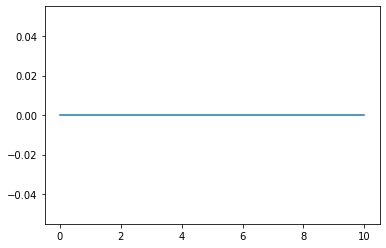

In [24]:
plt.plot(dset['x0'], dset['y0'])

In [8]:
np.shape(

SyntaxError: unexpected EOF while parsing (<ipython-input-8-3cf8d4e71000>, line 1)

In [9]:
len(np.shape(MC._setpoints))

1

# MC._setpoints[:, ]

In [10]:
len(np.shape())

TypeError: _shape_dispatcher() missing 1 required positional argument: 'a'

In [11]:
xP0 = t
yP0 = sig

In [12]:
x0pts = np.linspace(0, 10, 100)
x0R = xr.DataArray(data=x0pts, name=xP0.name, attrs={'long_name':xP0.label, 'unit':xP0.unit})


empty_arr = np.empty(np.shape(x0pts))
empty_arr[:] = np.nan
y0R = xr.DataArray(empty_arr, name=yP0.name, attrs={'long_name':yP0.label, 'unit': yP0.unit})

In [13]:
ds['t']

NameError: name 'ds' is not defined

In [14]:
ds = xr.merge([x0R, y0R])

In [58]:
ds['t'].values

array([ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ,
        0.50505051,  0.60606061,  0.70707071,  0.80808081,  0.90909091,
        1.01010101,  1.11111111,  1.21212121,  1.31313131,  1.41414141,
        1.51515152,  1.61616162,  1.71717172,  1.81818182,  1.91919192,
        2.02020202,  2.12121212,  2.22222222,  2.32323232,  2.42424242,
        2.52525253,  2.62626263,  2.72727273,  2.82828283,  2.92929293,
        3.03030303,  3.13131313,  3.23232323,  3.33333333,  3.43434343,
        3.53535354,  3.63636364,  3.73737374,  3.83838384,  3.93939394,
        4.04040404,  4.14141414,  4.24242424,  4.34343434,  4.44444444,
        4.54545455,  4.64646465,  4.74747475,  4.84848485,  4.94949495,
        5.05050505,  5.15151515,  5.25252525,  5.35353535,  5.45454545,
        5.55555556,  5.65656566,  5.75757576,  5.85858586,  5.95959596,
        6.06060606,  6.16161616,  6.26262626,  6.36363636,  6.46464646,
        6.56565657,  6.66666667,  6.76767677,  6.86868687,  6.96

In [59]:

ds['sig'].values[2] =3.4

In [60]:
ds['sig'].values

array([1. , nan, 3.4, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [61]:
print(ds)

<xarray.Dataset>
Dimensions:  (dim_0: 100)
Dimensions without coordinates: dim_0
Data variables:
    t        (dim_0) float64 0.0 0.101 0.202 0.303 ... 9.697 9.798 9.899 10.0
    sig      (dim_0) float64 1.0 nan 3.4 nan nan nan ... nan nan nan nan nan nan


In [66]:
ds = xr.merge([x0R, y0R])

In [67]:
ds.items()

ItemsView(<xarray.Dataset>
Dimensions:  (dim_0: 100)
Dimensions without coordinates: dim_0
Data variables:
    t        (dim_0) float64 0.0 0.101 0.202 0.303 ... 9.697 9.798 9.899 10.0
    sig      (dim_0) float64 1.0 nan 3.4 nan nan nan ... nan nan nan nan nan nan)

In [90]:
for i, x in enumerate(x0R.values):
#     print(x)
    xP0(x)
#     print(yP0())
    y0R.values[i] = yP0()
    

In [77]:
y0R.values

array([ 1.        ,  0.80527026,  0.29692038, -0.32706796, -0.82367658,
       -0.99949654, -0.78605309, -0.26647381,  0.35688622,  0.84125353,
        0.99798668,  0.76604444,  0.23575894, -0.38634513, -0.85798341,
       -0.99547192, -0.74526445, -0.20480667,  0.41541501,  0.87384938,
        0.99195481,  0.72373404,  0.17364818, -0.44406661, -0.88883545,
       -0.98743889, -0.70147489, -0.14231484,  0.47227107,  0.90292654,
        0.9819287 ,  0.67850941,  0.1108382 , -0.5       , -0.91610846,
       -0.97542979, -0.65486073, -0.07924996,  0.52722547,  0.92836793,
        0.9679487 ,  0.63055267,  0.04758192, -0.55392006, -0.93969262,
       -0.95949297, -0.60560969, -0.01586596,  0.58005691,  0.95007112,
        0.95007112,  0.58005691, -0.01586596, -0.60560969, -0.95949297,
       -0.93969262, -0.55392006,  0.04758192,  0.63055267,  0.9679487 ,
        0.92836793,  0.52722547, -0.07924996, -0.65486073, -0.97542979,
       -0.91610846, -0.5       ,  0.1108382 ,  0.67850941,  0.98

In [31]:
MC._setpoints = 

In [32]:
MC._setpoints

array([ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ,
        0.50505051,  0.60606061,  0.70707071,  0.80808081,  0.90909091,
        1.01010101,  1.11111111,  1.21212121,  1.31313131,  1.41414141,
        1.51515152,  1.61616162,  1.71717172,  1.81818182,  1.91919192,
        2.02020202,  2.12121212,  2.22222222,  2.32323232,  2.42424242,
        2.52525253,  2.62626263,  2.72727273,  2.82828283,  2.92929293,
        3.03030303,  3.13131313,  3.23232323,  3.33333333,  3.43434343,
        3.53535354,  3.63636364,  3.73737374,  3.83838384,  3.93939394,
        4.04040404,  4.14141414,  4.24242424,  4.34343434,  4.44444444,
        4.54545455,  4.64646465,  4.74747475,  4.84848485,  4.94949495,
        5.05050505,  5.15151515,  5.25252525,  5.35353535,  5.45454545,
        5.55555556,  5.65656566,  5.75757576,  5.85858586,  5.95959596,
        6.06060606,  6.16161616,  6.26262626,  6.36363636,  6.46464646,
        6.56565657,  6.66666667,  6.76767677,  6.86868687,  6.96

In [ ]:
xr.Dataset({}, )

In [24]:
import pandas as pd
temp = 15 + 8 * np.random.randn(2, 2, 3)

precip = 10 * np.random.rand(2, 2, 3)

lon = [[-99.83, -99.32], [-99.79, -99.23]]

lat = [[42.25, 42.21], [42.63, 42.59]]

test_ds = xr.Dataset({'temperature': (['x', 'y', 'time'],  temp),
                  'precipitation': (['x', 'y', 'time'], precip)},
                 coords={'lon': (['x', 'y'], lon),
                         'lat': (['x', 'y'], lat),
                         'time': pd.date_range('2014-09-06', periods=3),
                         'reference_time': pd.Timestamp('2014-09-05')})

In [26]:
xr.Dataset?

Init signature: xr.Dataset(*args, **kwds)
Docstring:     
A multi-dimensional, in memory, array database.

A dataset resembles an in-memory representation of a NetCDF file, and
consists of variables, coordinates and attributes which together form a
self describing dataset.

Dataset implements the mapping interface with keys given by variable names
and values given by DataArray objects for each variable name.

One dimensional variables with name equal to their dimension are index
coordinates used for label based indexing.
Init docstring:
To load data from a file or file-like object, use the `open_dataset`
function.

Parameters
----------
data_vars : dict-like, optional
    A mapping from variable names to :py:class:`~xarray.DataArray`
    objects, :py:class:`~xarray.Variable` objects or to tuples of the
    form ``(dims, data[, attrs])`` which can be used as arguments to
    create a new ``Variable``. Each dimension must have the same length
    in all variables in which it appears.

  

In [25]:
test_ds

<xarray.Dataset>
Dimensions:         (time: 3, x: 2, y: 2)
Coordinates:
    lon             (x, y) float64 -99.83 -99.32 -99.79 -99.23
    lat             (x, y) float64 42.25 42.21 42.63 42.59
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 2014-09-08
    reference_time  datetime64[ns] 2014-09-05
Dimensions without coordinates: x, y
Data variables:
    temperature     (x, y, time) float64 22.12 19.78 15.54 ... 2.444 8.32 4.651
    precipitation   (x, y, time) float64 2.002 7.45 0.4474 ... 8.386 1.118 6.188

In [4]:
MC.setable_pars()

[]

In [5]:
p0 = ManualParameter('p0')

In [8]:
MC.setable_pars([p0])

In [9]:
MC.setable_pars()

[<qcodes.instrument.parameter.ManualParameter: p0 at 4807988304>]

In [10]:
MC.setable_pars(p0, p0)

TypeError: set_wrapper() takes 1 positional argument but 2 were given

In [10]:
p0.unit

''

In [11]:
def cos_po():
    return np.cos(p0())

In [13]:
p1 = Parameter('p1', get_cmd=cos_po)

In [15]:
MC.setables(p0)

In [16]:
MC.getables(p1)

In [17]:
MC.run()

In [19]:
x0 = np.linspace(0, 30)

In [20]:
y0 = []
for x in x0: 
    p0(x)
    y0.append(p1())

In [31]:
from quantify.measurement.data_handling import gen_tuid

In [68]:
snap = MC.snapshot()
exclude_keys = {
    "inter_delay",
    "post_delay",
    "vals",
    "instrument",
    "functions",
    "__class__",
    "ts",
    "raw_value",
    "instrument_name",
    "full_name",
    "val_mapping",
    "setables",
    "getables",
}
cleaned_snapshot = delete_keys_from_dict(snap, exclude_keys)

In [69]:
cleaned_snapshot

{'submodules': {},
 'parameters': {'IDN': {'value': None,
   'label': 'IDN',
   'unit': '',
   'name': 'IDN'},
  'datadir': {'value': '', 'label': 'datadir', 'unit': '', 'name': 'datadir'}},
 'name': 'MC'}

In [70]:
x0r = xr.DataArray(x0, name=p0.name, attrs={'label':p0.label, 'unit':p0.unit})
y0r = xr.DataArray(y0, name=p1.name, attrs={'label':p1.label, 'unit':p1.unit})

dset = xr.Dataset({'x0': x0r, 'y0':y0r}, attrs={'tuid': gen_tuid(), 'snapshot': cleaned_snapshot})

In [71]:
dset.to_netcdf('test.hdf5')

TypeError: Invalid value for attr: {'submodules': {}, 'parameters': {'IDN': {'value': None, 'label': 'IDN', 'unit': '', 'name': 'IDN'}, 'datadir': {'value': '', 'label': 'datadir', 'unit': '', 'name': 'datadir'}}, 'name': 'MC'} must be a number, a string, an ndarray or a list/tuple of numbers/strings for serialization to netCDF files

In [45]:
new_dset = xr.open_dataset('test.hdf5')

In [46]:
new_dset

<xarray.Dataset>
Dimensions:  (dim_0: 50)
Dimensions without coordinates: dim_0
Data variables:
    x0       (dim_0) float64 ...
    y0       (dim_0) float64 ...
Attributes:
    tuid:     20200424-232315-8e90a7

In [52]:
cos_po.unit = 'a'

In [56]:
cos_po.get = cos_po.__call__

In [54]:
cos_po.name = 'cos'

In [55]:
cos_po.label='cos'

In [57]:
MC.getables(cos_po)

In [59]:
from quantify.measurement.measurement_control import is_getable, is_setable

In [60]:
from quantify.utilities.general import delete_keys_from_dict

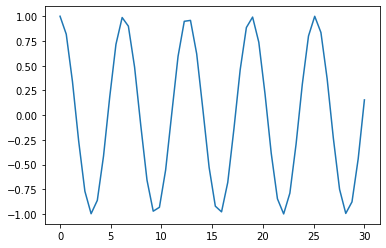

In [49]:
plt.plot(new_dset['x0'], new_dset['y0'])

In [36]:
MC.snapshot()

{'functions': {},
 'submodules': {},
 '__class__': 'quantify.measurement.measurement_control.MeasurementControl',
 'parameters': {'IDN': {'value': None,
   'ts': None,
   'raw_value': None,
   '__class__': 'qcodes.instrument.parameter.Parameter',
   'full_name': 'MC_IDN',
   'label': 'IDN',
   'unit': '',
   'inter_delay': 0,
   'instrument': 'quantify.measurement.measurement_control.MeasurementControl',
   'instrument_name': 'MC',
   'post_delay': 0,
   'name': 'IDN',
   'vals': '<Anything>'},
  'datadir': {'value': '',
   'ts': '2020-04-24 23:07:16',
   'raw_value': '',
   '__class__': 'qcodes.instrument.parameter.ManualParameter',
   'full_name': 'MC_datadir',
   'label': 'datadir',
   'unit': '',
   'inter_delay': 0,
   'instrument': 'quantify.measurement.measurement_control.MeasurementControl',
   'instrument_name': 'MC',
   'post_delay': 0,
   'name': 'datadir',
   'vals': '<Strings>'},
  'setables': {'value': <qcodes.instrument.parameter.ManualParameter: p0 at 4848886864>,
   't

In [37]:
dset

<xarray.Dataset>
Dimensions:  (dim_0: 50)
Dimensions without coordinates: dim_0
Data variables:
    x0       (dim_0) float64 0.0 0.6122 1.224 1.837 ... 28.16 28.78 29.39 30.0
    y0       (dim_0) float64 1.0 0.8184 0.3394 -0.2628 ... -0.877 -0.4416 0.1543
Attributes:
    tuid:      20200424-231655-157fb8
    snapshot:  {'functions': {}, 'submodules': {}, '__class__': 'quantify.mea...

In [39]:
dset.attrs['snapshot']

{'functions': {},
 'submodules': {},
 '__class__': 'quantify.measurement.measurement_control.MeasurementControl',
 'parameters': {'IDN': {'value': None,
   'ts': None,
   'raw_value': None,
   '__class__': 'qcodes.instrument.parameter.Parameter',
   'full_name': 'MC_IDN',
   'label': 'IDN',
   'unit': '',
   'inter_delay': 0,
   'instrument': 'quantify.measurement.measurement_control.MeasurementControl',
   'instrument_name': 'MC',
   'post_delay': 0,
   'name': 'IDN',
   'vals': '<Anything>'},
  'datadir': {'value': '',
   'ts': '2020-04-24 23:07:16',
   'raw_value': '',
   '__class__': 'qcodes.instrument.parameter.ManualParameter',
   'full_name': 'MC_datadir',
   'label': 'datadir',
   'unit': '',
   'inter_delay': 0,
   'instrument': 'quantify.measurement.measurement_control.MeasurementControl',
   'instrument_name': 'MC',
   'post_delay': 0,
   'name': 'datadir',
   'vals': '<Strings>'},
  'setables': {'value': <qcodes.instrument.parameter.ManualParameter: p0 at 4848886864>,
   't

In [29]:
dset.items

<bound method Mapping.items of <xarray.Dataset>
Dimensions:  (dim_0: 50)
Dimensions without coordinates: dim_0
Data variables:
    x0       (dim_0) float64 0.0 0.6122 1.224 1.837 ... 28.16 28.78 29.39 30.0
    y0       (dim_0) float64 1.0 0.8184 0.3394 -0.2628 ... -0.877 -0.4416 0.1543>

In [27]:
dset

<xarray.Dataset>
Dimensions:  (dim_0: 50)
Dimensions without coordinates: dim_0
Data variables:
    x0       (dim_0) float64 0.0 0.6122 1.224 1.837 ... 28.16 28.78 29.39 30.0
    y0       (dim_0) float64 1.0 0.8184 0.3394 -0.2628 ... -0.877 -0.4416 0.1543

In [ ]:
hasattr()